<a href="https://colab.research.google.com/github/matt-fidelis-95/Object-Detector/blob/master/Atividade_object_detection_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as T
import os
import xml.etree.ElementTree as ET
from PIL import Image,ImageDraw
from IPython.display import display
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Atividade_Mestrado')
from mapeval import voc_eval

In [ ]:
class MyDataset():
    def __init__(self,transforms = None):
        self.data = []
        self.transforms = transforms
        self.target_names = ['blanck']
        self.htarget_names = {'blanck':0}
        self.read_json()

    def get_label_id(self,name):
        if name not in self.htarget_names:
            self.htarget_names[name] = len(self.target_names)
            self.target_names.append(name)
        return self.htarget_names[name]
        
    def read_json(self):
        with open('labels.json') as json_file:
            data = json.load(json_file)
            for h in data:
                if 'objects' in h['Label']:
                    file_url = h['Labeled Data']
                    file_name = 'JPEGImages'+os.sep+h['External ID']
                    objects = h['Label']['objects']
                    boxes = []
                    labels = []
                    for obj in objects:
                        labels.append(self.get_label_id(obj['value']))
                        x1 = int(obj['bbox']['left'])
                        y1 = int(obj['bbox']['top'])
                        x2 = x1 + int(obj['bbox']['width'])
                        y2 = y1 + int(obj['bbox']['height'])
                        bbox  = [x1,y1,x2,y2]
                        boxes.append(bbox)
                    h = {}
                    h['file_img'] = file_name
                    h['labels'] = labels
                    h['boxes']  = boxes
                    self.data.append(h)
    def __getitem__(self,i):
        img   = Image.open(self.data[i]['file_img']).convert("RGB")
        boxes = torch.tensor(self.data[i]['boxes'])
        if self.transforms != None:
            img,boxes = self.transforms(img,boxes)
        r = dict()
        r['boxes']   = boxes
        r['labels']  = torch.tensor(self.data[i]['labels'])
        return img,r
    def __len__(self):
        return len(self.data)   

In [ ]:
def resize(img,boxes,size):
    w, h = img.size
    ow, oh = size
    sw = float(ow) / w
    sh = float(oh) / h
    img = img.resize((ow,oh), Image.BILINEAR)
    boxes = boxes * torch.tensor([sw,sh,sw,sh])
    return img, boxes

In [ ]:
size = (300,300)
def transform_data(img,boxes):
    img,boxes = resize(img,boxes,size)
    img = T.Compose([
          T.ToTensor(), 
          T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))          
    ])(img)
    return img,boxes

In [ ]:
data = MyDataset(transforms=transform_data)

In [ ]:
#a tecnica de amostragem usada foi o hold-out
n = len(data)
n_treino = int(0.8*n)
n_teste  = n-n_treino

In [ ]:
n,n_treino,n_teste

(127, 101, 26)

In [ ]:
ds_treino,ds_teste = torch.utils.data.random_split(data,(n_treino,n_teste))

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
dl_treino = torch.utils.data.DataLoader(ds_treino,batch_size = 8,collate_fn=collate_fn)
dl_teste  = torch.utils.data.DataLoader(ds_teste,batch_size = 12,collate_fn=collate_fn)

In [ ]:
imgs,targets = next(iter(dl_treino))

In [ ]:
def draw_boxes(img,boxes,labels):
    imdraw = ImageDraw.Draw(img)
    for (box,label) in zip(boxes,labels):
        box = list(box)
        imdraw.rectangle(box,outline='red')
        text = "%d"%(label)
        imdraw.text((box[0],box[1]),text,fill='red')
    display(img)

In [ ]:
nview = T.ToPILImage()(imgs[0]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))

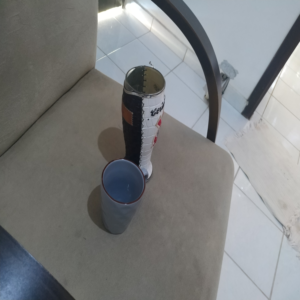

In [ ]:
nview

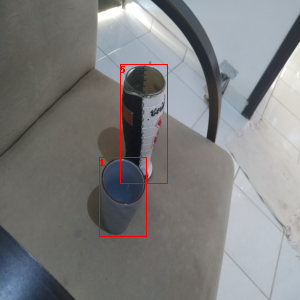

In [ ]:
draw_boxes(nview,targets[0]['boxes'],targets[0]['labels'])

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
torchvision.models.detection.FasterRCNN??

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes=6)

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
def train(epoch):
    model.train()
    bloss=[]
    for images,targets in dl_treino:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        
        opt.zero_grad()
        losses.backward()
        opt.step()
        #print(loss_dict)
        #wlog = {}
        for loss in loss_dict.keys():
            print("%.10s %4.3f"%(loss,loss_dict[loss].item()))
        print("Total Loss %4.3f\n"%(losses))
        bloss.append(losses.item())
    
    print("\nEPOCH %d LR %5.5f\n"%(epoch,opt.param_groups[0]['lr']))

In [ ]:
def evaluate(epoch):
    model.eval()
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    gt_boxes = []
    gt_labels = []
    lmap = []
    lap  = []
    with torch.no_grad():
        for images,targets in dl_teste:
            images = list(image.to(device) for image in images)
            pred   = model(images)
            for i in range(len(targets)):
                gt_boxes.append(targets[i]['boxes'])
                gt_labels.append(targets[i]['labels'])
                pred_boxes.append(pred[i]['boxes'].cpu())
                pred_labels.append(pred[i]['labels'].cpu())
                pred_scores.append(pred[i]['scores'].cpu())
                r = voc_eval(pred_boxes, pred_labels, pred_scores,
                gt_boxes, gt_labels)
                print(r)
                lmap.append(r['map'])
                #lap.append(r['ap'])
    print(np.mean(lmap))
    #print(np.mean(lap,axis=0))
    return np.mean(lmap)

In [ ]:
best_map,map_antigo = 0.0,0.0

In [ ]:
for epoch in range(100):
    train(epoch)
    map = evaluate(epoch)
    #early stopping: para se estiver ha 7 epocas sem mudar o map por um fator de 0.1%
    if (epoch%7 == 0) and (abs(map - map_antigo) > 0.001):
      map_antigo = map
    elif (epoch%7 == 0) and (abs(map - map_antigo) <= 0.001):
      break
    lr_scheduler.step(1.0-map)
    if map > best_map:
        best_map = map
        torch.save(model,'best_map_labelbox.pth')
        print('saving model')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


loss_class 1.181
loss_box_r 0.076
loss_objec 0.096
loss_rpn_b 0.021
Total Loss 1.374

loss_class 0.355
loss_box_r 0.128
loss_objec 0.025
loss_rpn_b 0.009
Total Loss 0.517

loss_class 0.492
loss_box_r 0.111
loss_objec 0.050
loss_rpn_b 0.009
Total Loss 0.662

loss_class 0.645
loss_box_r 0.169
loss_objec 0.134
loss_rpn_b 0.016
Total Loss 0.964

loss_class 0.330
loss_box_r 0.142
loss_objec 0.067
loss_rpn_b 0.009
Total Loss 0.548

loss_class 0.292
loss_box_r 0.142
loss_objec 0.094
loss_rpn_b 0.020
Total Loss 0.548

loss_class 0.337
loss_box_r 0.201
loss_objec 0.022
loss_rpn_b 0.012
Total Loss 0.572

loss_class 0.242
loss_box_r 0.141
loss_objec 0.035
loss_rpn_b 0.011
Total Loss 0.429

loss_class 0.213
loss_box_r 0.136
loss_objec 0.020
loss_rpn_b 0.010
Total Loss 0.379

loss_class 0.192
loss_box_r 0.101
loss_objec 0.032
loss_rpn_b 0.011
Total Loss 0.336

loss_class 0.253
loss_box_r 0.144
loss_objec 0.029
loss_rpn_b 0.011
Total Loss 0.437

loss_class 0.205
loss_box_r 0.133
loss_objec 0.012
los

In [ ]:
def draw_boxes_all(img,boxes,labels,scores):
    imdraw = ImageDraw.Draw(img)
    for (box,label,score) in zip(boxes,labels,scores):
        if score > 0.2:
            box = list(box)
            imdraw.rectangle(box,outline='red')
            text = "%4.3f %s"%(score,label)
            imdraw.text((box[0],box[1]),text,fill='red')
    display(img)

In [ ]:
model.to('cuda:0')

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model.eval()
data_teste = MyDataset(ds_teste)
for i in range(len(data_teste)):#range(len(data)):
    img   = Image.open(data_teste.data[i]['file_img']).convert("RGB")#Image.open(data.data[i]['file_img']).convert("RGB")
    w,h = img.size
    boxes = torch.tensor(data_teste.data[i]['boxes'])#torch.tensor(data.data[i]['boxes'])
    timg,tboxes = transform_data(img,boxes)
    _,rw,rh = timg.shape
    sw = float(w)/rw
    sh = float(h)/rh
    with torch.no_grad():
        timg2 = timg.view(1,3,300,300)
        timg2 = timg2.to(device)
        pred = model(timg2)
        #pred = pred.to(device)#pred.to(device)#
        #pred.cpu()
    boxes = pred[0]['boxes'] * torch.tensor([sw,sh,sw,sh]).to(device)
    labels_id = pred[0]['labels']
    labels = [data.target_names[id] for id in labels_id]
    scores = pred[0]['scores']
    draw_boxes_all(img,boxes,labels,scores)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


KeyboardInterrupt: ignored